# Feature engineering

### Libraries and loads data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import category_encoders as ce
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

d:\Dev\envs\SML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the cleaned dataset
filepath = "C:\\Users\\rosas\\OneDrive\\Desktop\\SML\\Project\\US_Accidents_Cleaned.csv"
df_cleaned = pd.read_csv(filepath)

df_transformed = df_cleaned.copy()
print("Data size after cleaning:", df_cleaned.shape)

numerical = df_cleaned.select_dtypes(include=['int64', 'float64'])
categorical = df_cleaned.select_dtypes(include=['object', 'category'])
boolean = df_cleaned.select_dtypes(include=['bool'])

# Print the number of features in each type
print(f"Numerical features: {numerical.shape[1]}")
print(f"Categorical features: {categorical.shape[1]}")
print(f"Boolean features: {boolean.shape[1]}")


Data size after cleaning: (166552, 44)
Numerical features: 11
Categorical features: 20
Boolean features: 13


Total unique regions: 22644
              count
count  22644.000000
mean       7.355238
std       16.775761
min        1.000000
25%        1.000000
50%        2.000000
75%        6.000000
max      457.000000


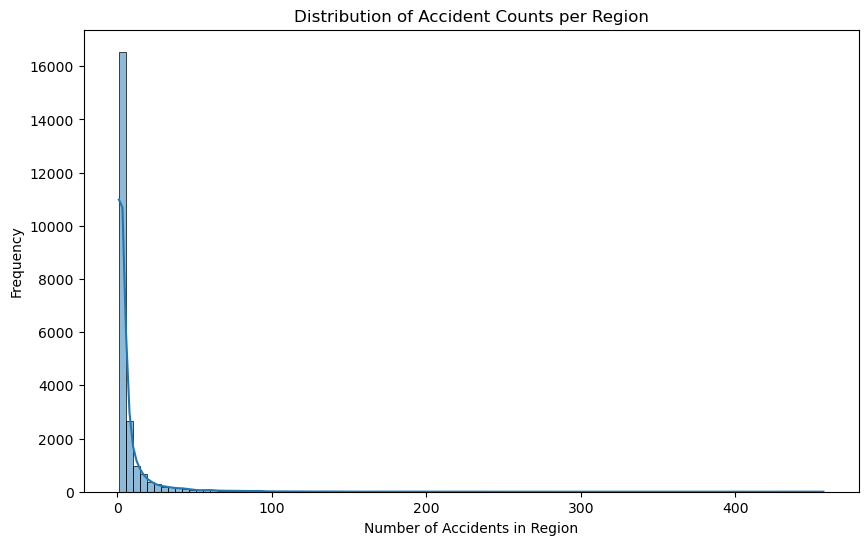

In [4]:
def count_records_per_region(df, grid_size=0.045):
    """
    Count how many accidents fall into each spatial grid cell.
    """
    df_temp = df.copy()

    # Compute grid coordinates
    df_temp['x_grid'] = (df_temp['Start_Lng'] // grid_size).astype(int)
    df_temp['y_grid'] = (df_temp['Start_Lat'] // grid_size).astype(int)
    df_temp['grid_id'] = df_temp['x_grid'].astype(str) + '_' + df_temp['y_grid'].astype(str)

    # Count number of records per region
    region_counts = df_temp['grid_id'].value_counts().reset_index()
    region_counts.columns = ['grid_id', 'count']

    print(f"Total unique regions: {region_counts.shape[0]}")
    print(region_counts.describe())

    return region_counts

# plot the distribution of records per region
region_counts = count_records_per_region(df_cleaned)
plt.figure(figsize=(10, 6))
sns.histplot(region_counts['count'], bins=100, kde=True)
plt.title('Distribution of Accident Counts per Region')
plt.xlabel('Number of Accidents in Region')
plt.ylabel('Frequency')
plt.show()


In [5]:
# print top 100 regions with highest counts
print(region_counts.head(100))

      grid_id  count
0   -2627_756    457
1   -2628_756    432
2   -2629_756    298
3   -2623_756    283
4   -2629_753    256
..        ...    ...
95  -2615_757    120
96  -1786_568    118
97  -1787_568    118
98  -2721_839    118
99  -2151_731    117

[100 rows x 2 columns]


We will only preserve the record for region with more than 2000 records

## Categorical features preprocessing

In [6]:
# Display unique values in each categorical column
for col in categorical.columns:
    print(f"{col}: {categorical[col].nunique()} unique values")

ID: 166552 unique values
Source: 1 unique values
Start_Time: 99280 unique values
End_Time: 124551 unique values
Description: 118040 unique values
Street: 36747 unique values
City: 6293 unique values
County: 1228 unique values
State: 45 unique values
Zipcode: 44640 unique values
Country: 1 unique values
Timezone: 4 unique values
Airport_Code: 1490 unique values
Weather_Timestamp: 23113 unique values
Wind_Direction: 18 unique values
Weather_Condition: 79 unique values
Sunrise_Sunset: 2 unique values
Civil_Twilight: 2 unique values
Nautical_Twilight: 2 unique values
Astronomical_Twilight: 2 unique values


C:\Users\rosas\AppData\Local\Temp\ipykernel_23256\1420617329.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_100_cities.index, x=top_100_cities.values, palette="viridis")


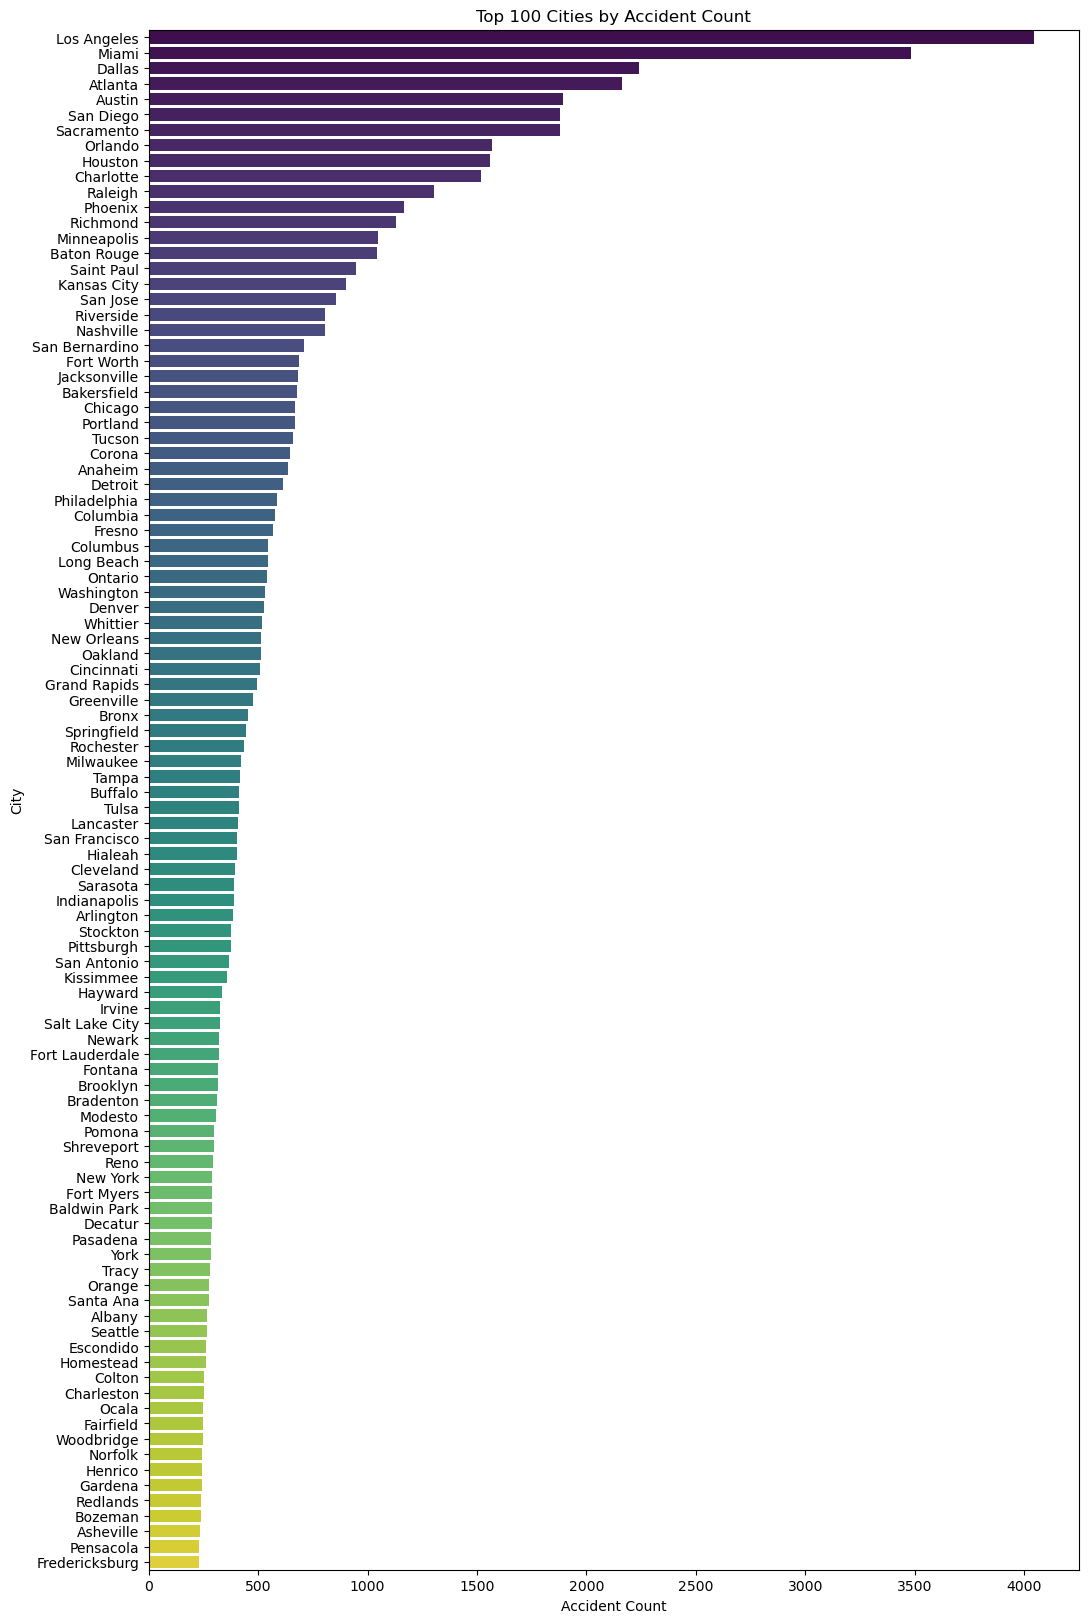

C:\Users\rosas\AppData\Local\Temp\ipykernel_23256\1420617329.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_100_counties.index, x=top_100_counties.values, palette="magma")


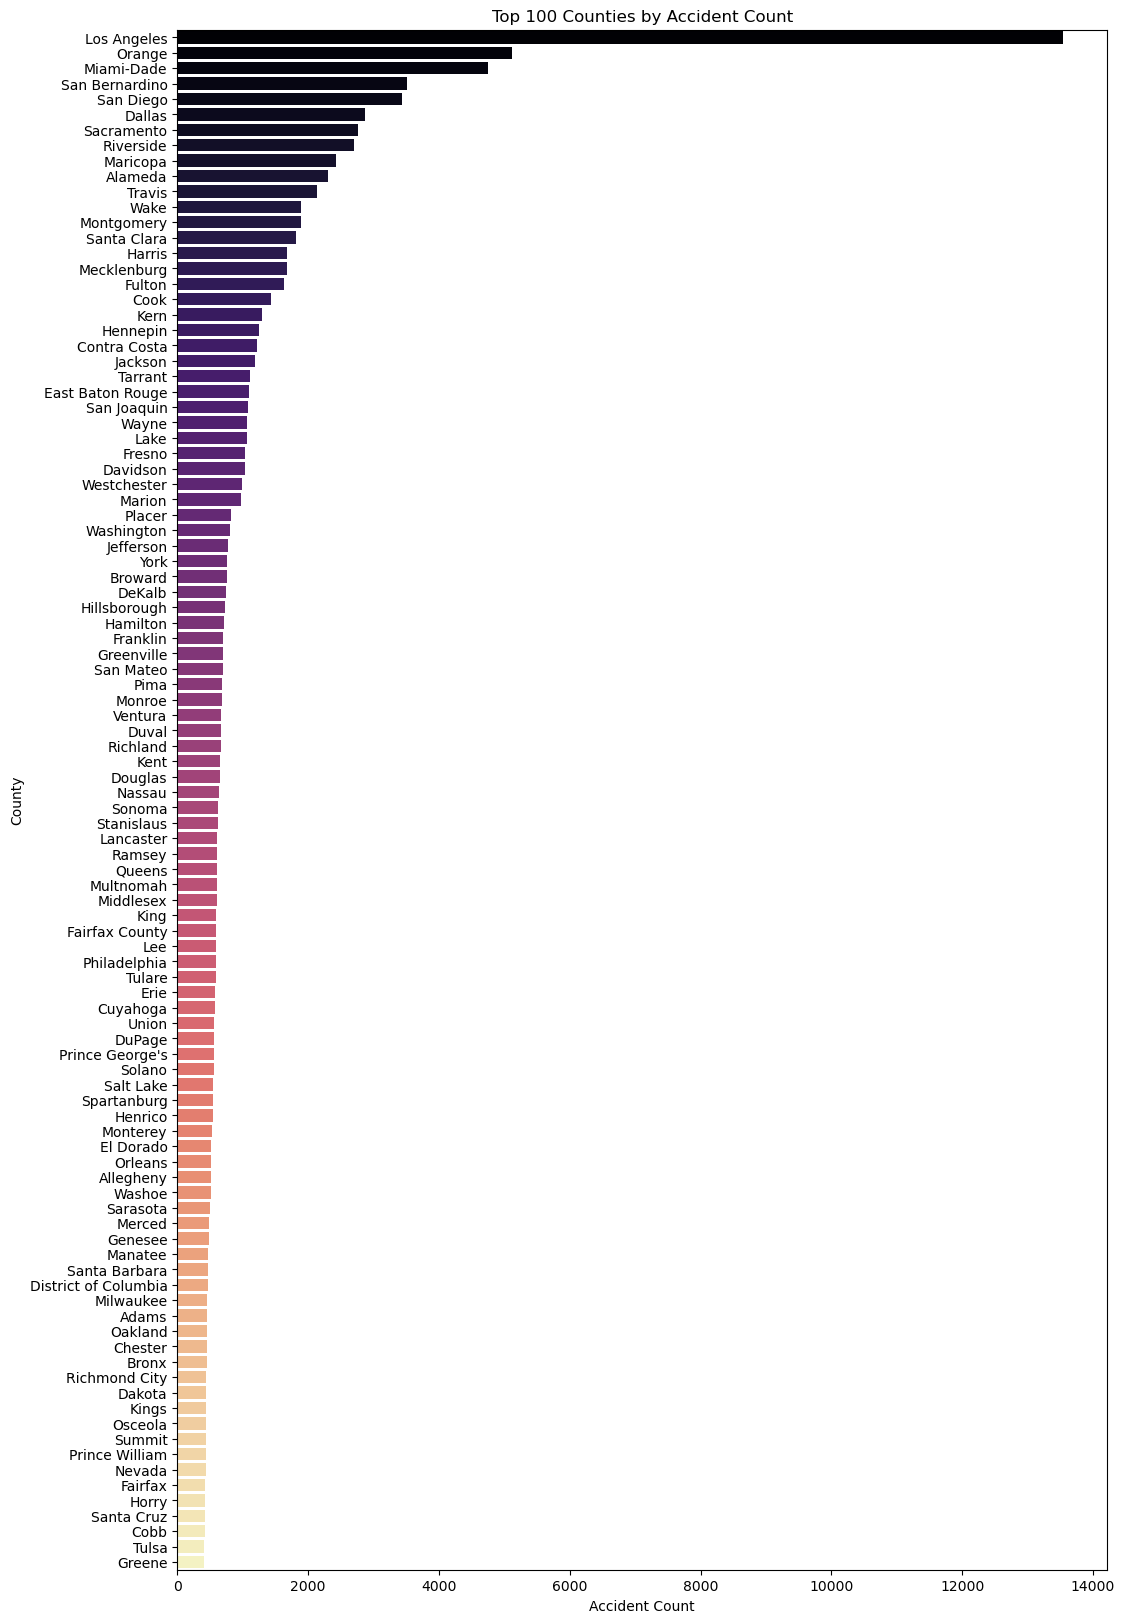

In [7]:
city_counts = df_transformed['City'].value_counts().sort_values(ascending=False)
top_100_cities = city_counts.head(100)
county_counts = df_transformed['County'].value_counts().sort_values(ascending=False)
top_100_counties = county_counts.head(100)

# Visualize top 100 cities and counties by accident counts
plt.figure(figsize=(12,20))
sns.barplot(y=top_100_cities.index, x=top_100_cities.values, palette="viridis")
plt.title(f"Top 100 Cities by Accident Count")
plt.xlabel("Accident Count")
plt.ylabel("City")
plt.show()

plt.figure(figsize=(12,20))
sns.barplot(y=top_100_counties.index, x=top_100_counties.values, palette="magma")
plt.title(f"Top 100 Counties by Accident Count")
plt.xlabel("Accident Count")
plt.ylabel("County")
plt.show()


In [8]:
print(df_transformed["Wind_Direction"].unique())
print(df_transformed["Weather_Condition"].unique())
print(df_transformed['Sunrise_Sunset'].unique())
print(df_transformed['Civil_Twilight'].unique())
print(df_transformed['Nautical_Twilight'].unique())
print(df_transformed['Astronomical_Twilight'].unique())

['E' nan 'S' 'NNE' 'ENE' 'N' 'NNW' 'NE' 'W' 'CALM' 'WNW' 'SSW' 'SW' 'VAR'
 'NW' 'SSE' 'WSW' 'SE' 'ESE']
['Mostly Cloudy' 'Fair' 'Light Rain with Thunder' 'Mist' 'Cloudy'
 'Light Snow' 'Partly Cloudy' 'Light Rain' 'Heavy T-Storm' nan 'Snow'
 'Rain' 'Fair / Windy' 'Showers in the Vicinity' 'Heavy Snow'
 'Rain / Windy' 'Mostly Cloudy / Windy' 'Snow and Sleet'
 'N/A Precipitation' 'Heavy Rain' 'Snow / Windy' 'Wintry Mix' 'Fog'
 'Drizzle' 'Cloudy / Windy' 'Haze' 'Light Rain / Windy' 'T-Storm'
 'Partly Cloudy / Windy' 'Light Drizzle' 'Light Drizzle / Windy'
 'Fog / Windy' 'Mist / Windy' 'Light Snow / Windy' 'Drizzle and Fog'
 'Heavy Rain / Windy' 'Light Rain Shower' 'Thunder'
 'Light Freezing Rain / Windy' 'T-Storm / Windy' 'Thunder in the Vicinity'
 'Snow and Sleet / Windy' 'Light Freezing Rain' 'Freezing Rain'
 'Rain Shower / Windy' 'Blowing Snow' 'Light Snow with Thunder'
 'Freezing Rain / Windy' 'Heavy Snow / Windy' 'Rain Shower'
 'Thunder / Wintry Mix' 'Wintry Mix / Windy' 'Blowing Dust

### Time related feature

In [9]:
def process_categorical_feature(df):
    df_featured = df.copy()
    # -----------------------------------------------------------------------------------------------------
    # Drop irrelevant categorical columns
    # -----------------------------------------------------------------------------------------------------

    Irrelevant_columns = ['ID', 'Source', 'Country'] 
    df_featured = df_featured.drop(columns=Irrelevant_columns)

    # -----------------------------------------------------------------------------------------------------
    # Time Feature Engineering
    # -----------------------------------------------------------------------------------------------------

    # Convert format of time related features
    df_featured['Start_Time'] = pd.to_datetime(df_featured['Start_Time'], errors='coerce')
    df_featured['End_Time'] = pd.to_datetime(df_featured['End_Time'], errors='coerce')

    # Extract time-based features
    df_featured['Start_Hour'] = df_featured['Start_Time'].dt.hour
    df_featured['Start_Day'] = df_featured['Start_Time'].dt.day
    df_featured['Start_Month'] = df_featured['Start_Time'].dt.month
    df_featured['Start_Year'] = df_featured['Start_Time'].dt.year
    df_featured['Start_DayOfWeek'] = df_featured['Start_Time'].dt.dayofweek
    df_featured['is_Weekend'] = df_featured['Start_DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    df_featured['duration_minutes'] = (df_featured['End_Time'] - df_featured['Start_Time']).dt.total_seconds() / 60

    # Preserve closeness of hours, day of weeks, and months
    df_featured['Start_Hour_sin'] = np.sin(2 * np.pi * df_featured['Start_Hour'] / 24)
    df_featured['Start_Hour_cos'] = np.cos(2 * np.pi * df_featured['Start_Hour'] / 24)
    df_featured['Start_DayOfWeek_sin'] = np.sin(2 * np.pi * df_featured['Start_DayOfWeek'] / 7)
    df_featured['Start_DayOfWeek_cos'] = np.cos(2 * np.pi * df_featured['Start_DayOfWeek'] / 7)
    df_featured['Start_Month_sin'] = np.sin(2 * np.pi * df_featured['Start_Month'] / 12)
    df_featured['Start_Month_cos'] = np.cos(2 * np.pi * df_featured['Start_Month'] / 12)

    # Construct features for rush hours
    df_featured['is_RushHour_Morning'] = df_featured['Start_Hour'].apply(lambda x: 1 if 7 <= x <= 9 else 0)
    df_featured['is_RushHour_Evening'] = df_featured['Start_Hour'].apply(lambda x: 1 if 16 <= x <= 18 else 0)

    # Construct Seasonal features
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
        
    df_featured['Season'] = df_featured['Start_Month'].apply(get_season)
    df_featured = pd.get_dummies(df_featured, columns=['Season'], prefix='is', drop_first=True, dtype=int)

    # -----------------------------------------------------------------------------------------------------
    # Location Feature Engineering
    # -----------------------------------------------------------------------------------------------------

    # binary encoding for 'Street' and 'zipcode'
    encoder = ce.BinaryEncoder(cols=['Street', 'Zipcode'])
    df_encoded = encoder.fit_transform(df_featured)

    # One-hot encoding for top 30 cities and counties
    top_50_cities = city_counts.head(30)
    top_50_counties = county_counts.head(30)
    for city in top_50_cities.index:
        df_featured[f'City_{city}'] = (df_featured['City'] == city).astype(int)
    for county in top_50_counties.index:
        df_featured[f'County_{county}'] = (df_featured['County'] == county).astype(int)

    # One-hot encoding for 'State'
    state_dummies = pd.get_dummies(df_featured, columns=['State'], prefix='State', drop_first=True)

    # One-hot encoding for 'Timezone'
    timezone_dummies = pd.get_dummies(df_featured, columns=['Timezone'], prefix='Timezone', drop_first=True)

    # Drop original 'City', 'County', 'Street', and 'Zipcode' columns
    df_featured = df_featured.drop(columns=['City', 'County', 'Street', 'Zipcode', 'State', 'Timezone'])

    # -----------------------------------------------------------------------------------------------------
    # Weather Feature Engineering
    # -----------------------------------------------------------------------------------------------------

    # Drop the 'airport_code' column due to high cardinality and low relevance
    df_featured = df_featured.drop(columns=['Airport_Code'])

    # Compute the lag between weather timestamp and accident start time
    df_featured['Weather_Timestamp'] = pd.to_datetime(df_featured['Weather_Timestamp'], errors='coerce')
    df_featured['Weather_Lag_Mins'] = (df_featured['Start_Time'] - df_featured['Weather_Timestamp']).dt.total_seconds() / 60

    # Drop original time columns
    df_featured = df_featured.drop(columns=['Start_Time', 'End_Time', 'Weather_Timestamp'])

    # Mapping wind direction to numerical values
    wind_dir_map = {
        'N': 0, 'North': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90, 'East': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180, 'South': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270, 'West': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5,
        'CALM': np.nan, 'VAR': np.nan, 'Variable': np.nan,
    }

    # Apply mapping
    df_featured['Wind_Direction_Degrees'] = df_featured['Wind_Direction'].map(wind_dir_map)

    # Use cyclic encoding for wind direction
    df_featured['Wind_Direction_sin'] = np.sin(2 * np.pi * df_featured['Wind_Direction_Degrees'] / 360)
    df_featured['Wind_Direction_cos'] = np.cos(2 * np.pi * df_featured['Wind_Direction_Degrees'] / 360)

    # Drop original 'Wind_Direction' and intermediate 'Wind_Direction_Degrees' columns
    df_featured = df_featured.drop(columns=['Wind_Direction', 'Wind_Direction_Degrees'])

    # Construct a weather map
    weather_map = {
        # Clear
        'Clear': 'Clear', 'Fair': 'Clear', 'Fair / Windy': 'Clear',
        
        # Cloudy
        'Cloudy': 'Cloudy', 'Mostly Cloudy': 'Cloudy', 'Partly Cloudy': 'Cloudy',
        'Overcast': 'Cloudy', 'Scattered Clouds': 'Cloudy',
        'Cloudy / Windy': 'Cloudy', 'Mostly Cloudy / Windy': 'Cloudy',
        'Partly Cloudy / Windy': 'Cloudy',
        
        # Rain / Drizzle
        'Rain': 'Rain', 'Light Rain': 'Rain', 'Heavy Rain': 'Rain',
        'Light Drizzle': 'Rain', 'Drizzle': 'Rain', 'Heavy Drizzle': 'Rain',
        'Showers in the Vicinity': 'Rain', 'Light Rain Showers': 'Rain',
        'Light Rain Shower': 'Rain', 'Light Rain / Windy': 'Rain',
        'Rain / Windy': 'Rain', 'Drizzle / Windy': 'Rain',
        'Light Drizzle / Windy': 'Rain',
        
        # Thunderstorms
        'T-Storm': 'Storm', 'Heavy T-Storm': 'Storm',
        'Heavy T-Storm / Windy': 'Storm', 'Thunder': 'Storm',
        'Thunder / Windy': 'Storm', 'Thunder in the Vicinity': 'Storm',
        'Thunderstorms and Rain': 'Storm', 'Heavy Thunderstorms and Rain': 'Storm',
        'Light Thunderstorms and Rain': 'Storm',
        'Thunder and Hail': 'Storm', 'T-Storm / Windy': 'Storm',
        'Thunder / Wintry Mix': 'Storm', 'Thunder / Wintry Mix / Windy': 'Storm',
        'Light Thunderstorms and Snow': 'Storm',
        
        # Snow
        'Snow': 'Snow', 'Light Snow': 'Snow', 'Heavy Snow': 'Snow',
        'Blowing Snow': 'Snow', 'Drifting Snow': 'Snow',
        'Light Snow / Windy': 'Snow', 'Snow / Windy': 'Snow',
        'Heavy Snow / Windy': 'Snow', 'Blowing Snow / Windy': 'Snow',
        'Drifting Snow / Windy': 'Snow',
        
        # Wintry Mix / Ice
        'Wintry Mix': 'Ice', 'Wintry Mix / Windy': 'Ice',
        'Sleet': 'Ice', 'Light Sleet': 'Ice',
        'Snow and Sleet': 'Ice', 'Snow and Sleet / Windy': 'Ice',
        'Light Snow and Sleet': 'Ice', 'Light Snow and Sleet / Windy': 'Ice',
        'Ice Pellets': 'Ice', 'Light Ice Pellets': 'Ice',
        'Freezing Rain': 'Ice', 'Light Freezing Rain': 'Ice',
        'Light Freezing Rain / Windy': 'Ice',
        'Light Freezing Drizzle': 'Ice', 'Light Freezing Fog': 'Ice',
        
        # Fog / Mist / Haze
        'Fog': 'Fog', 'Fog / Windy': 'Fog',
        'Shallow Fog': 'Fog', 'Patches of Fog': 'Fog',
        'Patches of Fog / Windy': 'Fog', 'Mist': 'Fog',
        'Drizzle and Fog': 'Fog', 'Haze': 'Fog', 'Haze / Windy': 'Fog',
        
        # Smoke / Dust
        'Smoke': 'Dust/Smoke', 'Smoke / Windy': 'Dust/Smoke',
        'Widespread Dust': 'Dust/Smoke', 'Blowing Dust': 'Dust/Smoke',
        'Blowing Dust / Windy': 'Dust/Smoke', 'Sand / Dust Whirlwinds': 'Dust/Smoke',
        'Squalls / Windy': 'Dust/Smoke',
        
        # Severe
        'Tornado': 'Severe',
        
        # Unknown
        'Unknown': 'Unknown', 'N/A Precipitation': 'Unknown'
    }

    # Apply the mapping
    df_featured['Weather_Condition_Cat'] = df_featured['Weather_Condition'].map(weather_map)

    # One-hot encode the new weather condition categories
    df_featured = pd.get_dummies(df_featured, columns=['Weather_Condition_Cat'], prefix='Weather', drop_first=True, dtype=int)

    # Drop original 'Weather_Condition'
    df_featured = df_featured.drop(columns=['Weather_Condition'])

    # Construct a binary mapping
    twilight_map = {
        'Day': 1,
        'Night': 0
    }

    binary_cols_to_map = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
    for col in binary_cols_to_map:
        df_featured[col + '_binary'] = df_featured[col].map(twilight_map)
        df_featured = df_featured.drop(columns=[col])

    return df_featured

### Description Feature Processing (Pretrained Sentence Embedding)

In [10]:
def process_description_embeddings(df):
    df_featured = df.copy()
    # Load pre-trained sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Generate embeddings for the 'Description' column
    descriptions = df_featured['Description'].fillna("").tolist()
    embeddings = model.encode(descriptions, show_progress_bar=True, batch_size=64)

    # Convert embeddings to DataFrame
    embeddings_df = pd.DataFrame(embeddings, columns=[f'Desc_Emb_{i}' for i in range(embeddings.shape[1])])
    df_featured = pd.concat([df_featured.reset_index(drop=True), embeddings_df.reset_index(drop=True)], axis=1)

    # Drop original 'Description' column
    df_featured = df_featured.drop(columns=['Description'])

    return df_featured

## Boolean Features Processing

In [11]:
# Display unique values in each Boolean column
for col in boolean.columns:
    print(f"{col}: {boolean[col].nunique()} unique values")
    #Print unique values in each Boolean column
    print(boolean[col].unique())

Amenity: 2 unique values
[False  True]
Bump: 2 unique values
[False  True]
Crossing: 2 unique values
[False  True]
Give_Way: 2 unique values
[False  True]
Junction: 2 unique values
[False  True]
No_Exit: 2 unique values
[False  True]
Railway: 2 unique values
[False  True]
Roundabout: 2 unique values
[False  True]
Station: 2 unique values
[False  True]
Stop: 2 unique values
[False  True]
Traffic_Calming: 2 unique values
[False  True]
Traffic_Signal: 2 unique values
[False  True]
Turning_Loop: 1 unique values
[False]


In [12]:
def process_boolean_feature(df):
    df_featured = df.copy()
        # Binarize remaining boolean columns
    for col in boolean.columns:
        df_featured[col] = df_featured[col].astype(int)
            
    return df_featured


### 

## Numerical features Processing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166552 entries, 0 to 166551
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Severity           166552 non-null  int64  
 1   Start_Lat          166552 non-null  float64
 2   Start_Lng          166552 non-null  float64
 3   Distance(mi)       166552 non-null  float64
 4   Temperature(F)     166552 non-null  float64
 5   Wind_Chill(F)      166552 non-null  float64
 6   Humidity(%)        166552 non-null  float64
 7   Pressure(in)       166552 non-null  float64
 8   Visibility(mi)     166552 non-null  float64
 9   Wind_Speed(mph)    166552 non-null  float64
 10  Precipitation(in)  166552 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 14.0 MB
None


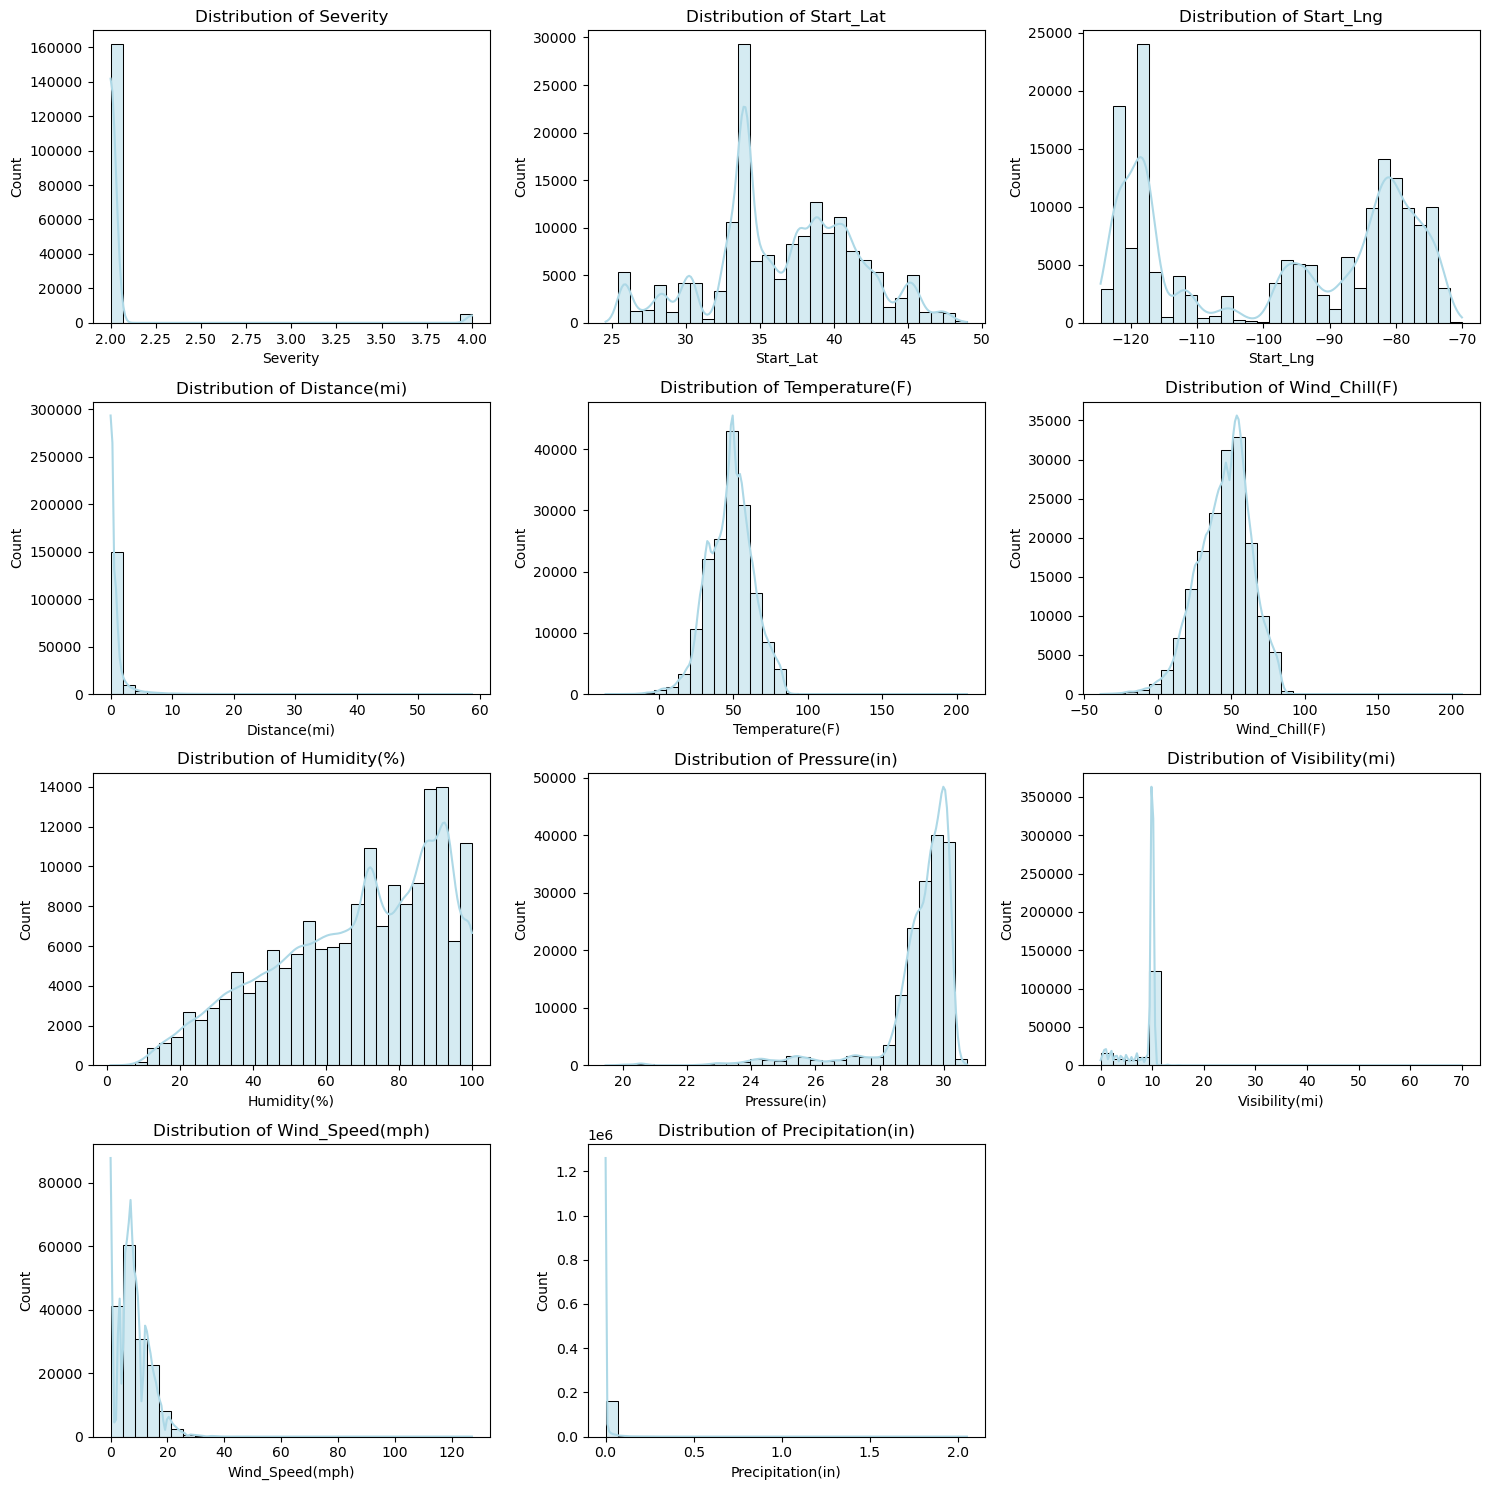

In [13]:
# Display numerical feature
print(numerical.info())
plt.figure(figsize=(15, 15))
for i, col in enumerate(numerical.columns):
    plt.subplot(len(numerical.columns)//3 + 1, 3, i + 1)
    sns.histplot(df_transformed[col], kde=True, bins=30, color='lightblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Process numerical feature

In [14]:
def process_numerical_feature(df, scaler=StandardScaler()):
    weather_numerical_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Wind_Chill(F)',
                            'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
    df_featured = df.copy()
    # log-transform skewed features
    skewed_features = ['Wind_Speed(mph)', 'Visibility(mi)']
    for feature in skewed_features:
        df_featured[feature] = np.log1p(df_featured[feature])

    # Construct binary features for precipitation
    df_featured['Has_Precipitation'] = (df_featured['Precipitation(in)'] > 0).astype(int)

    # Normalize rest of numerical features
    for feature in weather_numerical_cols:
        if feature not in skewed_features and feature != 'Precipitation(in)':
            df_featured[feature] = scaler.fit_transform(df_featured[[feature]])
    
    return df_featured

## Aggregate dataset based on geocoordinate

In [102]:
from time import process_time_ns


def aggregate_features(df, grid_size=1.0, PCA_on_embeddings=True, embedding_dim=50):
    df_region = df.copy()

    # Define grid cells based on lat/lng
    df_region['x_grid'] = (df_region['Start_Lng'] // grid_size).astype(int)
    df_region['y_grid'] = (df_region['Start_Lat'] // grid_size).astype(int)
    df_region['grid_id'] = df_region['x_grid'].astype(str) + '_' + df_region['y_grid'].astype(str)
    df_region = df_region.drop(columns=['Start_Lat', 'Start_Lng'])

    # Identify feature columns
    embedding_cols = [col for col in df_region.columns if col.startswith('Desc_Emb_')]
    bool_cols = [col for col in df_region.columns if df_region[col].isin([0, 1]).all()]
    numerical_cols = df_region.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in bool_cols + embedding_cols + ['Severity', 'x_grid', 'y_grid']]

    # Define aggregation dictionary
    agg_dict = {col: 'mean' for col in numerical_cols}
    agg_dict.update({col: 'mean' for col in bool_cols})
    agg_dict['Severity'] = 'sum'  # Sum of severity to capture both frequency & dangerousness

    # Apply aggregation
    df_agg = df_region.groupby('grid_id').agg(agg_dict).reset_index()

    # Mean pooling for embeddings
    if embedding_cols:
        df_embeddings = df_region.groupby('grid_id')[embedding_cols].mean().reset_index()

        if PCA_on_embeddings:
            pca = PCA(n_components=embedding_dim, random_state=62)
            embedding_reduced = pca.fit_transform(df_embeddings[embedding_cols])

            embedding_reduced_df = pd.concat([df_embeddings[['grid_id']], 
                 pd.DataFrame(embedding_reduced, columns=[f'Emb_PCA_{i}' for i in range(embedding_dim)])],axis=1)

            df_agg = df_agg.merge(embedding_reduced_df, on='grid_id', how='left')
        else:
            df_agg = df_agg.merge(df_embeddings, on='grid_id', how='left')

    bins = [0, 10, 100, float('inf')]
    labels = [0, 1, 2]
    df_agg['risk_level'] = pd.cut(df_agg['Severity'], bins=bins, labels=labels, right=False).astype(int)

    # Convert numeric types to consistent float64
    num_cols = df_agg.select_dtypes(include=['number']).columns
    df_agg[num_cols] = df_agg[num_cols].astype('float64')

    return df_agg




In [92]:
df = pd.read_csv(filepath)
print("Original data size:", df.shape)
print("start processing categorical features...")
df = process_categorical_feature(df)
print("start processing description embeddings...")
df = process_description_embeddings(df)
print("start processing boolean features...")
df = process_boolean_feature(df)
print("start processing numerical features...")
df = process_numerical_feature(df)


Original data size: (166552, 44)
start processing categorical features...
start processing description embeddings...


Batches: 100%|██████████| 2603/2603 [08:08<00:00,  5.32it/s]


start processing boolean features...
start processing numerical features...


In [103]:
df_final = aggregate_features(df, grid_size=0.1, PCA_on_embeddings=True, embedding_dim=50)

In [104]:
print("Final aggregated data size:", df_final.shape)

Final aggregated data size: (11167, 161)


C:\Users\rosas\AppData\Local\Temp\ipykernel_23256\3784272058.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


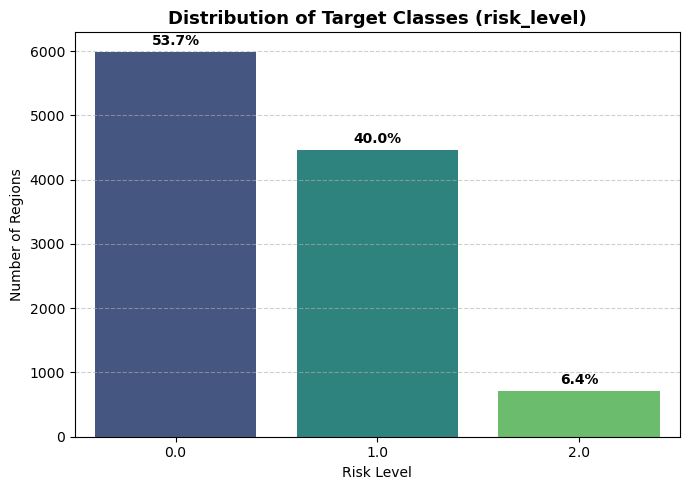

Target Class Distribution:


,Count,Percent
risk_level,,
0.0,5992,53.66
1.0,4462,39.96
2.0,713,6.38


In [105]:
# Check that your final dataset has the correct label column
label_col = 'risk_level'

# Compute distribution
class_counts = df_final[label_col].value_counts().sort_index()
class_percent = (class_counts / class_counts.sum()) * 100

plt.figure(figsize=(7,5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

for i, val in enumerate(class_counts.values):
    plt.text(i, val + max(class_counts.values)*0.01, f"{class_percent.iloc[i]:.1f}%", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title(f"Distribution of Target Classes ({label_col})", fontsize=13, fontweight='bold')
plt.xlabel("Risk Level" if label_col=='risk_level' else "Hotspot Label")
plt.ylabel("Number of Regions")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Target Class Distribution:")
display(pd.DataFrame({
    "Count": class_counts,
    "Percent": class_percent.round(2)
}))


In [88]:
print("top 1000 'Severity' values:")
print(df_final['Severity'].value_counts().head(1000)) 
print("75th percentile:", df_final['Severity'].quantile(0.75))

top 1000 'Severity' values:
Severity
2       2514
4       1552
6       1113
8        813
10       621
        ... 
786        1
904        1
1088       1
696        1
234        1
Name: count, Length: 277, dtype: int64
75th percentile: 20.0


## Examine the final constructed dataset and save

In [106]:
# Double check for any non-numerical columns
for col in df_final.columns:
    if df_final[col].dtype != 'float64':
        print(f"Column {col} has dtype {df_final[col].dtype}")

Column grid_id has dtype object


In [107]:
df_final.to_csv("C:\\Users\\rosas\\OneDrive\\Desktop\\SML\\Project\\US_Accidents_Featured_Engineered.csv", index=False)